In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import os
import warnings
import json
from datetime import datetime
import os
from datetime import datetime as dt
from sentinelhub import CRS, BBox, DataCollection, SentinelHubCatalog, SHConfig
from sentinelhub.aws import AwsDownloadClient
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

warnings.filterwarnings('ignore')

In [4]:
from sentinelhub import SHConfig

In [5]:

#https://sentinelhub-py.readthedocs.io/en/latest/examples/aws_request.html

boto_params = {"RequestPayer": "requester"}
config = SHConfig()
s3_client = AwsDownloadClient.get_s3_client(config)


In [6]:
# My info
config.instance_id = 'c7442d27-ca9f-406a-8b59-76a13034d289'
config.sh_client_id = '72f63f2f-3f76-4b8b-b6b6-fb28a0694a28'
config.sh_client_secret = '3mO~G/4wKHfiEB5JC8Q!wTQ~fK1j_]/GgLH#:6gp'
config.save()

In [9]:
# open shape files for Cameroon
import geopandas as gpd
sh_cmr = gpd.read_file("/Users/noeliaotero/Documents/Geo_analysis/cmr/cmr.shp")

<AxesSubplot: >

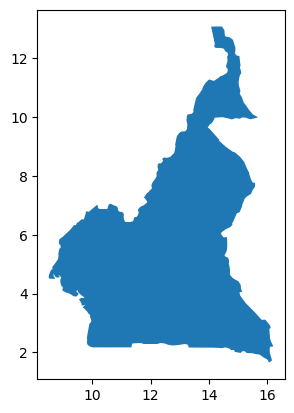

In [10]:
sh_cmr.plot()

In [11]:
sh_cmr  = sh_cmr.to_crs("EPSG:4326")
bbx_cmr = sh_cmr.total_bounds


In [12]:
search_bbox = BBox(bbox=tuple(map(float, bbx_cmr)), crs=CRS.WGS84)
search_time_interval = (datetime(2022, 1, 1), datetime(2022, 12, 31))


In [13]:
dataL2A = DataCollection.SENTINEL2_L2A
data_collection = DataCollection.SENTINEL2_L1C 

In [34]:
#data_collection = DataCollection.SENTINEL2_L1C

In [14]:
def get_s3_tile_paths(search_bbox, search_time_interval, data_collection, config):
    """Get the images directily from AWS"""
    results = SentinelHubCatalog(config).search(collection=data_collection, bbox=search_bbox, time=search_time_interval)

    return [result["assets"]["data"]["href"] for result in results]

In [15]:
get_s3_tile_paths(search_bbox, search_time_interval, dataL2A, config)

DownloadFailedException: Failed to download from:
https://services.sentinel-hub.com/api/v1/catalog/1.0.0/search
with HTTPError:
403 Client Error: Forbidden for url: https://services.sentinel-hub.com/api/v1/catalog/1.0.0/search
Server response: "{"code": 403, "description": "Invalid or expired account."}"

In [39]:
get_s3_tile_paths(search_bbox, search_time_interval, dataL2A, config)

['s3://sentinel-s2-l2a/tiles/38/L/PH/2022/12/14/0/',
 's3://sentinel-s2-l2a/tiles/38/L/PJ/2022/12/14/0/',
 's3://sentinel-s2-l2a/tiles/38/L/PK/2022/12/14/0/',
 's3://sentinel-s2-l2a/tiles/38/L/PL/2022/12/14/0/',
 's3://sentinel-s2-l2a/tiles/38/L/PM/2022/12/14/0/',
 's3://sentinel-s2-l2a/tiles/38/L/PN/2022/12/14/0/',
 's3://sentinel-s2-l2a/tiles/38/L/PP/2022/12/14/0/',
 's3://sentinel-s2-l2a/tiles/38/L/PM/2022/12/12/0/',
 's3://sentinel-s2-l2a/tiles/38/L/PN/2022/12/12/0/',
 's3://sentinel-s2-l2a/tiles/38/L/PP/2022/12/12/0/',
 's3://sentinel-s2-l2a/tiles/38/L/PQ/2022/12/12/0/',
 's3://sentinel-s2-l2a/tiles/38/L/PR/2022/12/12/0/']

In [38]:
def list_tile_objects(s3_tile_path):
    """Returns list of all files, which are located on `s3 path` on s3 bucket."""
    _, _, bucket_name, url_key = s3_tile_path.split("/", 3)
    return s3_client.list_objects_v2(Bucket=bucket_name, Prefix=url_key, **boto_params)["Contents"]


In [43]:
list_of_objects = tile_objects_list = list_tile_objects("s3://sentinel-s2-l1c/tiles/38/L/PH/2022/12/14/0/")
print(len(list_of_objects))

65


In [45]:
def download(s3_tile_path, download_dir, objects_to_download=None):
    """"Download files"""
    os.makedirs(download_dir, exist_ok=True)
    all_files = list_tile_objects(s3_tile_path)

    for file in all_files:
        file_name = file["Key"].split("/")[-1]
        if not objects_to_download or file_name in objects_to_download:
            out_path = os.path.join(download_dir, file_name)
            _, _, bucket_name, _ = s3_tile_path.split("/", 3)
            s3_client.download_file(Bucket=bucket_name, Key=file["Key"], Filename=out_path, ExtraArgs=boto_params)


In [46]:
files_to_download = ["B04.jp2", "B07.jp2"]
download("s3://sentinel-s2-l1c/tiles/38/L/PH/2022/12/14/0/", "/Users/noeliaotero/Documents/Geo_analysis/data/", files_to_download)
